In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


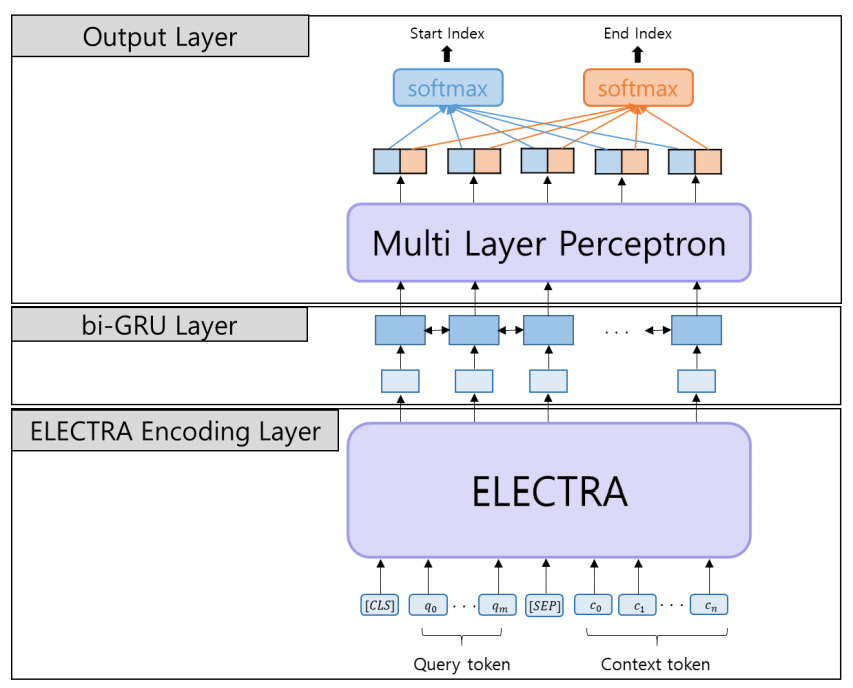

In [ ]:
from IPython.display import Image
import os
root_dir = '/gdrive/MyDrive/14-1.MachineReadingComprehension'
Image(os.path.join(root_dir, "MRC_practice.PNG"))

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.2 MB/s 
     |████████████████████████████████| 120 kB 74.5 MB/s 
     |████████████████████████████████| 6.6 MB 59.0 MB/s 


In [ ]:
from tqdm import tqdm
from torch import nn
import numpy as np
import random
import torch

from transformers import ElectraTokenizer, ElectraConfig
from transformers import ElectraModel, ElectraPreTrainedModel


from torch.utils.data import DataLoader

from transformers import (
    squad_convert_examples_to_features
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor
from transformers.data.metrics.squad_metrics import (
    compute_predictions_logits,
    squad_evaluate,
)

In [ ]:
class ElectraForQuestionAnswering(ElectraPreTrainedModel):
    def __init__(self, config):
        super(ElectraForQuestionAnswering, self).__init__(config)

        # 분류해야할 라벨 수 (start / end)
        self.num_labels = config.num_labels

        # ELECTRA 모델 선언
        self.electra = ElectraModel(config)

        # 최종 출력
        self.qa_outputs = nn.Linear(config.hidden_size, config.num_labels)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
    ):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids
        )
        # ouputs :  batch, max_length, hidden_size
        #
        # config.output_hidden_states = True
        # [12 + 1, batch, seq_length, hidden] [-1]
        # trm output * 12 + embedding layer * 1

        # config.output_attentions = True
        # [12, batch, seq_length, seq_length]
        # 위 두 설정 적용시 아래의 return 값을 가짐
        #           electra_output, (all_layer_output, all_layer_attention)

        sequence_output = outputs[0]
        # sequence_output : [batch, max_length, hidden_size]

        logits = self.qa_outputs(sequence_output)
        # logits : [batch, max_length, 2]

        start_logits, end_logits = logits.split(1, dim=-1)
        # start_logits : [batch, max_length, 1]
        # end_logits : [batch, max_length, 1]

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        # start_logits : [batch, max_length]
        # end_logits : [batch, max_length]

        return start_logits, end_logits

In [ ]:
def tensor2list(tensor):
    return tensor.detach().cpu().tolist()

def load_dataset(config, tokenizer, evaluate=False, output_examples=False):
    # 데이터 전처리를 위한 함수
    # example : 최대 길이 상관 없이 원문 그대로 저장되어있는 데이터 (질문, 문서, 정답 위치 (어절 기준))
    #         : context: "세종대왕은 조선의 4대 왕으로 ~~~"
    #
    # feature : 최대 길이에 맞춰 분할되어있는 원문 + 인덱스 데이터 (질문 + slice 문서, 정답 위치 (WP 기준), 위치 offset)
    #         : [세종, 대, 왕은, 조],  ~~         [1, 6, 3, 4, 34]
    #           [대, 왕은, 조, 선의], [왕은, 조, 선의, 4]
    # dataset : 최대 길이에 맞춰 분할되어있는 tensor dataset (질문 + slice 문서 (Tensor), 정답 위치)
    #         : [42, 6, 23, 5], [123, 356, 234, 4, 12] ~~~

    processor = SquadV1Processor()

    # 실행 모드에 따라 데이터를 load
    # 학습 시, 사전 부착되어있는 정답까지 Load
    # 평가 시, 정답 Load X
    if evaluate:
        examples = processor.get_dev_examples(config["data_dir"],
                                              filename=config["predict_file"])
    else:
        examples = processor.get_train_examples(config["data_dir"],
                                                filename=config["train_file"])

    features, dataset = squad_convert_examples_to_features(
        examples=examples,
        tokenizer=tokenizer,
        max_seq_length=config["max_seq_length"],
        doc_stride=config["doc_stride"],
        max_query_length=config["max_query_length"],
        is_training=not evaluate,
        return_dataset="pt"
    )
    if output_examples:
        return dataset, examples, features
    return dataset

In [ ]:
# 모델의 가중치를 Load하는 부분
def _create_model(config):
    print("Create Model with Pretrained Parameters...")
    electra_config = ElectraConfig.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
    )
    electra_tokenizer = ElectraTokenizer.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
        do_lower_case=config["do_lower_case"],
    )
    model = ElectraForQuestionAnswering.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"], "checkpoint-{}".format(config["checkpoint"])),
        config=electra_config
    )

    model.cuda()

    return config, model, electra_tokenizer


In [ ]:
def train(config, model, tokenizer):
    # 데이터 읽기
    train_dataset = load_dataset(config, tokenizer, evaluate=False, output_examples=False)

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=config["batch_size"])

    # optimizer 선언
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    global_step = 0

    # 크로스엔트로피 손실 함수
    loss_func = nn.CrossEntropyLoss()

    best_f1 = 0
    for epoch in range(config["num_epochs"]):
        for step, batch in enumerate(train_dataloader):
            # 학습 모드 셋팅
            model.train()

            # .cuda()를 통해 데이터를 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, start_positions, end_positions = batch[:5]

            start_hypothesis, end_hypothesis = model(input_ids, attention_mask, token_type_ids)
            # start_hypothesis : [batch, max_length]
            # end_hypothesis : [batch, max_length]

            # Loss 계산 및 역전파
            start_loss = loss_func(start_hypothesis, start_positions)
            end_loss = loss_func(end_hypothesis, end_positions)

            loss = start_loss + end_loss

            loss.backward()

            optimizer.step()
            model.zero_grad()
            global_step += 1

            # 중간 결과 출력
            if global_step % 50 == 0:
                print("{} step Current Loss : {}".format(global_step, loss.item()))

            # 특정 checkpoint 마다 저장 및 평가
            if global_step % 500 == 0:
                results = test(config, model, tokenizer, global_step)
                for key in sorted(results.keys()):
                    print("  {} = {}".format(key, str(results[key])))
                cur_f1 = results['f1']

                if cur_f1 > best_f1:
                    best_f1 = cur_f1

                    # 모델 저장을 위한 부분
                    output_dir = os.path.join(config["output_dir"], "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)

                    # 모델 및 vocab 저장
                    model.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(model.state_dict, os.path.join(output_dir, "training_args.bin"))
                    print("Saving model checkpoint to ", output_dir)

In [ ]:
def test(config, model, tokenizer, global_step):
    # 데이터 읽기
    dataset, examples, features = load_dataset(config, tokenizer, evaluate=True, output_examples=True)

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    eval_dataloader = DataLoader(dataset, shuffle=True, batch_size=config["batch_size"])

    # 모델 출력 결과를 저장하기위한 list
    all_results = []

    for step, batch in enumerate(tqdm(eval_dataloader)):
        # 평가 모드 세팅
        model.eval()

        # .cuda()를 통해 데이터를 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)
        with torch.no_grad():
            input_ids, attention_mask, token_type_ids = batch[:3]

            # batch size와 관계 없는 Global index
            feature_unique_ids = batch[3]
            # example_indices : [batch]
            #                 batch step 1 => [0, 1, 2, 3]
            #                 batch step 2 => [4, 5, 6, 7] ...

            hypothesis = model(input_ids, attention_mask, token_type_ids)

        for i, feature_unique_id in enumerate(feature_unique_ids):
            eval_feature = features[feature_unique_id.item()]

            # unique_id : dataset과 feature가 공유하는 id
            unique_id = int(eval_feature.unique_id)

            # hypothesis : [s_hypothesis : [batch, seq_len], e_hypothesis : [batch, seq_len]]
            # [2, batch, seq_length]
            output = [tensor2list(output[i]) for output in hypothesis]
            start_hypothesis, end_hypothesis = output
            # s_h : [seq_length] / e_h : [seq_length]
            result = SquadResult(unique_id, start_hypothesis, end_hypothesis)

            all_results.append(result)

    # Compute predictions
    output_prediction_file = os.path.join(config["output_dir"], "predictions_{}.json".format(global_step))
    output_nbest_file = os.path.join(config["output_dir"], "nbest_predictions_{}.json".format(global_step))

    predictions = compute_predictions_logits(
        all_examples=examples,
        all_features=features,
        all_results=all_results,
        n_best_size=config["n_best_size"],
        max_answer_length=config["max_answer_length"],
        # tp==세종은 ~~~~. 세종은~~~
        #     ^
        #                     ^
        do_lower_case=config["do_lower_case"],
        output_prediction_file=output_prediction_file,
        output_nbest_file=output_nbest_file,
        tokenizer=tokenizer,
        verbose_logging=True,
        #########################################
        # for no answer prediction
        version_2_with_negative=False,
        null_score_diff_threshold=None,
        output_null_log_odds_file=None
    )

    # 모델 예측 출력
    for idx in range(0, 100, 10):
        input_question = examples[idx].question_text
        input_context = examples[idx].context_text
        predict_answer = predictions[examples[idx].qas_id]
        answer = examples[idx].answers[0]["text"]
        print("############################# Predict Sample ####################################")
        print("input Question : ", input_question)
        print("input Context : ", input_context)
        print("Correct Answer : ", answer)
        print("Predict Answer : ", predict_answer)
        print("\n\n")

    # Compute the F1 and exact scores.
    results = squad_evaluate(examples, predictions)

    return results

In [ ]:
# 아래의 코드는 example, feature, dataset 사이의 관계를 파악해야 이해에 도움이 됩니다.
# 아래는 example, feature, dataset의 간단한 설명입니다.

# example : 질문과 문서가 원문 그대로 저장된 객체입니다.
# ex) example : {
# 				"question_text": "세종은 조선의 몇 대 왕이야?"
# 				"context_text" : "세종은 조선의 4대 왕으로, ~~~"
# 				...
# 			  }

# feature : example과 유사하게 질문과 문서의 내용을 저장하고 있지만,
# 모델 입력 길이에 맞춰 slice 된 "[CLS] 질문 [SEP] 문서 [SEP]" 꼴의 WP index list와 WP list를 포함하고 있습니다.
# ex) example : {
# 				"input_ids": [0, 45, 654, 14, 456, 7345, 2344, 457, 23, 1293, 1, 45, 654, ..., 1, 2, ...]
# 				"tokens" : [[CLS], 세종, 은, 조선, 의, 몇, 대, 왕이, 야, ?, [SEP], 세종, 은, ... [SEP], [Pad], ... ]
# 				...
# 			  }

# dataset : feature에 저장된 input_ids, attention_mask 등 학습에 필요한 요소를 tensor 형태로 변환한 TensorDataset 타입의 객체입니다.

batch = tuple(t.cuda() for t in batch)
with torch.no_grad():
	input_ids, attention_mask, token_type_ids = batch[:3]
	# dataset에 저장된 input_ids, attention_mask, token_type_ids 저장

	feature_unique_ids = batch[3]
	# feature_unique_id는 dataset에 1:1로 대응되는 각 feature의 고유 번호입니다.
	# ex) batch size가 4인 경우
	# 	첫 번째 batch step에서의 feature_unique_id : [0, 1, 2, 3]
	# 	두 번째 batch step에서의 feature_unique_id : [4, 5, 6, 7]

	hypothesis = model(input_ids, attention_mask, token_type_ids)
	# hypothesis는 [s_hypothesis, e_hypothesis]입니다.
	# 이때, s_hypothesis e_hypothesis 모양은 각각 (batch_size, seq_length)이기 때문에
	# hypothesis는 (2, batch_size, seq_length)의 크기를 갖습니다.


	# 아래의 반복문은 batch_size 만큼의 크기를 갖고있는 hypothesis를 하나하나 쪼개기 위한 단계입니다.
	for i, feature_unique_id in enumerate(feature_unique_ids):
		# feature의 전체 list인 features에서 feature_unique_id로 접근하여 feature를 하나씩 불러옴
		eval_feature = features[feature_unique_id.item()]

		# unique_id : dataset과 feature가 공유하는 id
		unique_id = int(eval_feature.unique_id)

		output = [tensor2list(output[i]) for output in hypothesis]
		# output ∈ [s_hypothesis, e_hypothesis] # 즉, batch_size만큼 값을 가지고 있는 s_hypothesis와 e_hypothesis에서
		# s_hypothesis : (batch_size, seq_length) # batch_size에 대해 반복하는 i 번째 요소 값을 가져옴
		# e_hypothesis : (batch_size, seq_length)

		# hypothesis : (2, batch_size, seq_length)
		# output : (2, seq_length)
		start_hypothesis, end_hypothesis = output

		result = SquadResult(unique_id, start_hypothesis, end_hypothesis)

		all_results.append(result)

In [ ]:
if __name__ == "__main__":
    output_dir = os.path.join(root_dir, "output")
    data_dir = os.path.join(root_dir, "data")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    config = {
        "mode": "test",
        "data_dir": data_dir,
        "output_dir": output_dir,
        "train_file": "KorQuAD_v1.0_train.json",
        "predict_file": "KorQuAD_v1.0_dev.json",
        "init_weight": "monologg/koelectra-small-v3-discriminator",
        "do_lower_case": False,
        "checkpoint": 6000,
        "batch_size": 16,
        "num_epochs": 5,
        "max_seq_length": 512,
        "max_query_length": 64,
        "max_answer_length": 30,
        "n_best_size": 20,
        "learning_rate": 5e-5,
        "doc_stride": 128,
    }
    config, model, tokenizer = _create_model(config)
    if config["mode"] == "train":
        train(config, model, tokenizer)
    elif config["mode"] == "test":
        results = test(config, model, tokenizer, config["checkpoint"])
        for key in sorted(results.keys()):
            print("  {} = {}".format(key, str(results[key])))


Create Model with Pretrained Parameters...


100%|██████████| 174/174 [00:16<00:00, 10.30it/s]


############################# Predict Sample ####################################
input Question :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
input Context :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
Correct Answer :  1989년 2월 15일
Predict Answer :  1989년 2월 15일



############################# Predict Sample ####################################
input Question :  법무부 장관을 제쳐놓고 민정수석이 개정안을 설명하는 게 이해가 안 된다고 지적한 경희대 석좌교수 이름은?
input Context :  "내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10차 개헌안 발표이다. 원로 헌법학자인 허영 경희대 석좌교수는 정부의 헌법개정안 준비 